# Model Predictive Control of Hybrid Systems

Given the state of the system at time zero $x(0)$, we solve the following (open-loop) optimal-control problem 
\begin{align}
V^*(x(0)) :=
\min_{x(\cdot), u(\cdot)} \quad &
\frac{1}{2} \sum_{t=0}^{N-1} x^T(t) Q x(t) + u^T(t) R u(t) + \frac{1}{2} x^T(N) P x(N),
\\
\text{subject to} \quad & x(t+1) = A_i x(t) + B_i u(t) + c_i
\quad \text{if} \quad
(x(t),u(t)) \in \mathcal D_i
,
\quad i \in \{ 1, \ldots, s\}
,
\quad t=0,\ldots, N-1,
\\
& x(N) \in \mathcal X_N,
\end{align}
we apply the control $u(0)$ to the system, and we move to the next time step.

Assuming $c_1 = 0$ and $0 \in \mathrm{int} (D_1)$, we can ensure stability choosing $P$ as the solution of the infinite-horizon DARE for the system in mode $i = 1$, and $\mathcal{X}_N$ as any constraint-admissible invariant set for the system in mode $1$ in closed loop with the LQR controller.

## Demo

In [1]:
# notebook settings
%load_ext autoreload
%autoreload 2

# external imports
import numpy as np
import matplotlib.pyplot as plt

# internal imports
from pympc.geometry.polyhedron import Polyhedron
from pympc.dynamics.discrete_time_systems import LinearSystem, AffineSystem, PieceWiseAffineSystem
from pympc.control.controllers import HybridModelPredictiveController
from pympc.plot import plot_input_sequence, plot_state_trajectory, plot_state_space_trajectory

We stabilize a linear inverted pendulum with mass $m$ and length $l$, subject to the gravity acceleration $g$; the pendulum is allowed to impact with an elastic wall with stiffness $k$ placed at distance $d$ from the vertical line passing trough the hinge

In [2]:
m = 1.
l = 1.
g = 10.
k = 100.
d = .1
h = .01

We express the linearized dynamics in PieceWise Affine (PWA) form
\begin{equation}
\dot x =
\begin{cases}
A_1 x + B_1 u, \quad \text{if} \quad (x, u) \in \mathcal D_1, \\
A_2 x + B_2 u + c_2, \quad \text{if} \quad (x, u) \in \mathcal D_2,
\end{cases}
\end{equation}

with

\begin{equation}
A_1 = 
\begin{bmatrix}
0 & 1 \\ g/l & 0
\end{bmatrix},
\quad
B_1 = 
\begin{bmatrix}
0 \\ 1/(ml^2)
\end{bmatrix},
\quad
A_2 = 
\begin{bmatrix}
0 & 1 \\ g/l - k/m & 0
\end{bmatrix},
\quad
B_2 = 
\begin{bmatrix}
0 \\ 1/(ml^2)
\end{bmatrix},
\quad
c_2 = 
\begin{bmatrix}
0 \\ kd/(ml)
\end{bmatrix},
\end{equation}

\begin{equation}
\mathcal D_1 =
\{ (x,u) \ | \
x_1 \leq d/l, \
x_{\mathrm{min}} \leq x \leq x_{\mathrm{max}}, \
u_{\mathrm{min}} \leq u \leq u_{\mathrm{max}} \},
\end{equation}

\begin{equation}
\mathcal D_2 =
\{ (x,u) \ |
\ x_1 > d/l, \
x_{\mathrm{min}} \leq x \leq x_{\mathrm{max}},
\ u_{\mathrm{min}} \leq u \leq u_{\mathrm{max}} \}
\end{equation}

In [3]:
# discretization method
method = 'explicit_euler'

# dynamics n.1
A1 = np.array([[0., 1.],[g/l, 0.]])
B1 = np.array([[0.],[1/(m*l**2.)]])
S1 = LinearSystem.from_continuous(A1, B1, h, method)

# dynamics n.2
A2 = np.array([[0., 1.],[g/l-k/m, 0.]])
B2 = B1
c2 = np.array([0., k*d/(m*l)])
S2 = AffineSystem.from_continuous(A2, B2, c2, h, method)

# list of dynamics
S_list = [S1, S2]

The domains of the PWA must be expressed as (bounded!) polyhedra

In [4]:
# state domain n.1
x1_min = np.array([-2.*d/l, -1.5])
x1_max = np.array([d/l, 1.5])
X1 = Polyhedron.from_bounds(x1_min, x1_max)
assert X1.bounded

# state domain n.2
x2_min = np.array([d/l, -1.5])
x2_max = np.array([2.*d/l, 1.5])
X2 = Polyhedron.from_bounds(x2_min, x2_max)
assert X2.bounded

# input domain
u_min = np.array([-4.])
u_max = np.array([4.])
U = Polyhedron.from_bounds(u_min, u_max)
assert U.bounded

# domains
D1 = X1.cartesian_product(U)
D2 = X2.cartesian_product(U)
D_list = [D1, D2]

The overall PWA system can be defines as follows

In [5]:
S = PieceWiseAffineSystem(S_list, D_list)

We can now synthesize the controller

In [6]:
# controller parameters
N = 20
Q = np.eye(S.nx)
R = np.eye(S.nu)

# terminal set and cost
P, K = S1.solve_dare(Q, R)
X_N = S1.mcais(K, D1)

# hybrid MPC controller
controller = HybridModelPredictiveController(S, N, Q, R, P, X_N)

We now compare the open-loop and the closed-loop behaviour of the controller, with the inverted pendulum starting from the initial state $x_0$

In [7]:
# initial state
x0 = np.array([.0, .8])

# open-loop control
u_ol, x_ol, ms_ol, V_ol = controller.feedforward(x0)

# closed-loop control
Nsim = 100
u_cl = []
x_cl = [x0]
for t in range(Nsim):
    print('Time step ' + str(t) + '.\r'),
    u_cl.append(controller.feedback(x_cl[t]))
    x_next = S.simulate(x_cl[t], [u_cl[t]])[0][1]
    x_cl.append(x_next)

The open-loop trajectory is forced to reach the terminal set $\mathcal{X}_N$ in $N$ steps, whereas the closed-loop controller at each time step can relax the trajectory of the previous optimization thanks to the shifted horizon (note that, in case the terminal constraint is not active for the open-loop controller, the two controller behave identically)

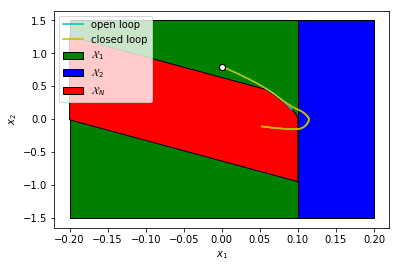

In [8]:
X1.plot(label=r'$\mathcal{X}_1$', facecolor='g')
X2.plot(label=r'$\mathcal{X}_2$', facecolor='b')
X_N.plot(label=r'$\mathcal{X}_N$', facecolor='r')
plot_state_space_trajectory(x_ol, label='open loop', color='c')
plot_state_space_trajectory(x_cl, label='closed loop', color='y')
plt.legend()
plt.show()

Finally we can plot the closed-loop trajectory as a function of time

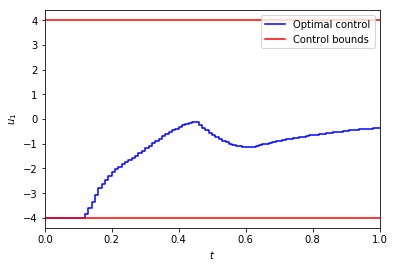

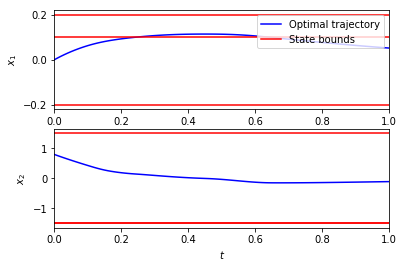

In [9]:
plot_input_sequence(u_cl, h, (u_min, u_max))
plt.show()
plot_state_trajectory(x_cl, h, (x1_min, x2_min, x2_max))
plt.show()